In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

In [80]:
series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")['Count']

In [91]:
#Для временного ряда и заданной длины окна сформирмуем матрицу траектории
N = len(series)
t = np.arange(0,N)
L = 50 #длина окна
K = N - L + 1 #число колонок в матрице траекторий
 
X = np.column_stack([series[i:i+L] for i in range(0,K)])
X

array([[ 41,  39,  50, ..., 276, 224, 213],
       [ 39,  50,  40, ..., 224, 213, 279],
       [ 50,  40,  43, ..., 213, 279, 268],
       ...,
       [ 78,  99, 107, ..., 316, 398, 394],
       [ 99, 107, 112, ..., 398, 394, 431],
       [107, 112,  90, ..., 394, 431, 431]], dtype=int64)

In [83]:
#разложим полученную матрицу сингулярным разложением и построим элементарные матрицы
d = np.linalg.matrix_rank(X) #ранг матрицы траектории
U, Sigma, V = np.linalg.svd(X)
V = V.T 

X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0, d)])

In [74]:
#усредним элементарные матрицы, чтобы сформировать элементарные компоненты вреемнного ряда
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

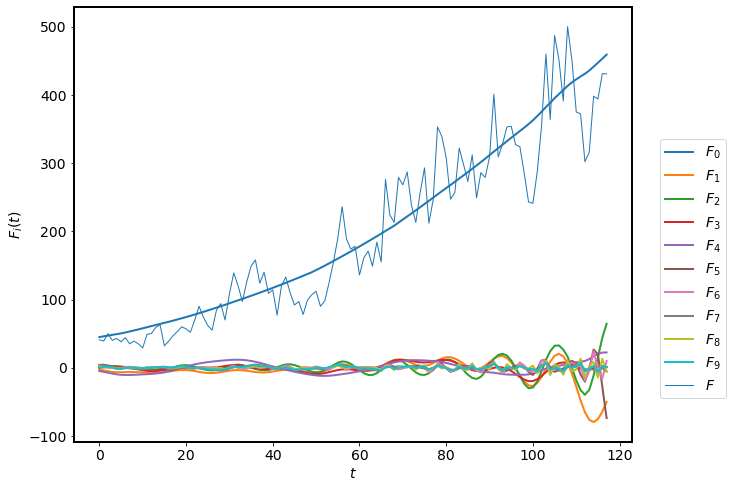

In [104]:
n = min(10,d)
fig = plt.subplot()

for i in range(n):
    series_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, series_i, lw=2)
    
fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"${F}_i(t)$")
legend = [r"${F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.legend(legend, loc=(1.05,0.1));    

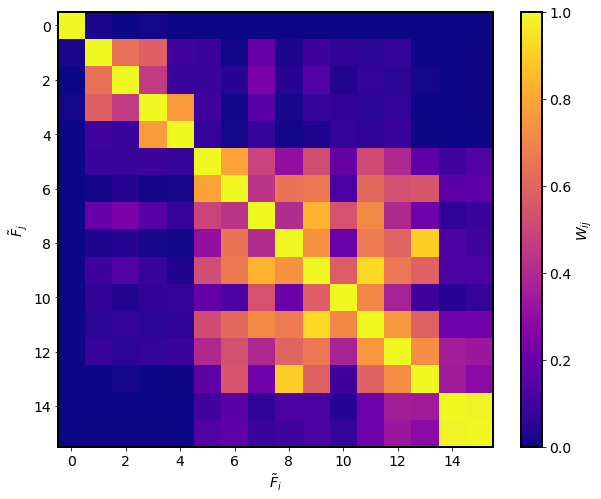

In [94]:
#построим взвешенную корреляционную матрицу

w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,15.5)
plt.ylim(15.5,-0.5)
plt.clim(0,1)

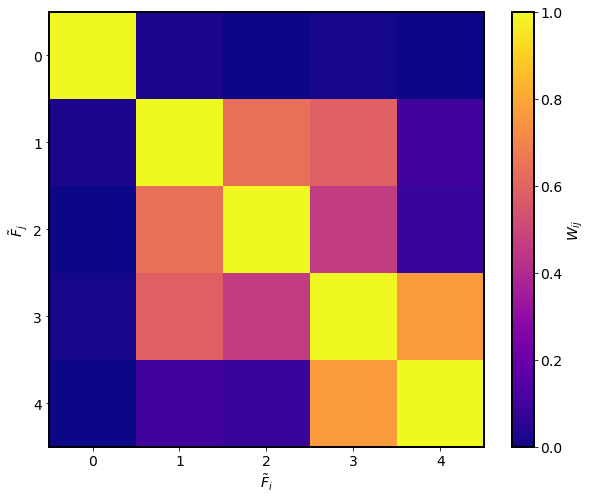

In [96]:
#оставим компоненты 0-4
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,4.5)
plt.ylim(4.5,-0.5)
plt.clim(0,1)

Text(0, 0.5, '${F}(t)$')

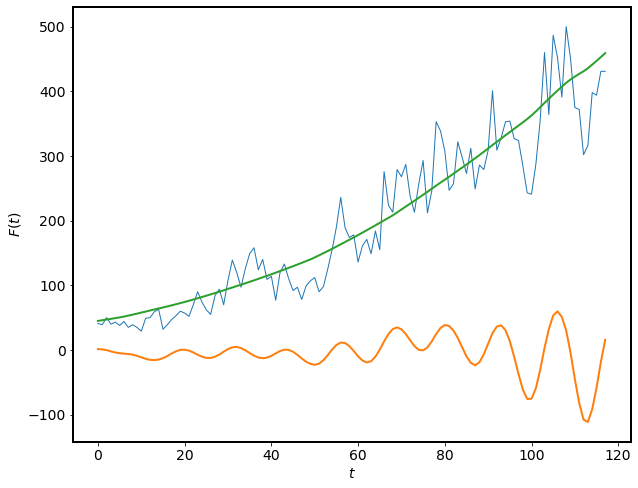

In [103]:
#выделим составляющую тренда и сезонности
F_season = np.sum([F_elem[1], F_elem[2], F_elem[3]], axis=0)
F_trend = F_elem[0]
fig = plt.subplot()


fig.axes.plot(t, series, alpha=1, lw=1)
fig.axes.plot(t, F_season, lw=2)
fig.axes.plot(t, F_trend, lw=2)

fig.set_xlabel("$t$")
fig.set_ylabel(r"${F}(t)$")
